<a href="https://colab.research.google.com/github/OscarAlvaradoM/Introduccion-al-Aprendizaje-Profundo/blob/main/tarea1/Tarea1_P3_IAP_OscarAlvarado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 3.-
Entrena una red completamente conectada para aproximar la compuerta XOR.

In [126]:
import numpy as np
import matplotlib.pyplot as plt
# tomar n elementos de una secuencia
from itertools import islice as take
# redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# barras de progreso
from tqdm import trange
from torch.utils.data import TensorDataset, DataLoader 

In [130]:
# definición del modelo
class FCN(nn.Module):
    # inicializador
    def __init__(self, capas=2,neuronas=3):
        
        # inicilización del objeto padre, obligatorio
        super(FCN, self).__init__()
        
        # tamaño de las capas
        self.I = 1 * 2 * 1

        FC1, FC15, FC2 = neuronas, neuronas, 2

        # definición de capas
        if capas == 1:
            self.cls = nn.Sequential(
                # fc1
                # [M, 3x32x32] => [M, 128]
                nn.Linear(self.I, FC1),
                nn.ReLU(),
                # fc2
                # [M, 128] => [M, 10]
                nn.Linear(FC1, FC2)
            )
        elif capas == 2:
            self.cls = nn.Sequential(
                # fc1
                # [M, 3x32x32] => [M, 128]
                nn.Linear(self.I, FC1),
                nn.ReLU(),
                # fc15
                # [M, 3x32x32] => [M, 128]
                nn.Linear(FC1, FC15),
                nn.ReLU(),
                # fc2
                # [M, 128] => [M, 10]
                nn.Linear(FC15, FC2)
            )

    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 1, 2, 1] => [M, 1x2x1]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 1x2x1]
        x = self.cls(x)
        
        return x

In [115]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        
        # computamos logits
        y_lgts = model(x)
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):

            # computamos los logits
            y_lgts = model(x)

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optim.SGD(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [116]:
X_train = torch.normal(mean=torch.zeros(10000,2), std=torch.ones(10000,2))
y_true = X_train[:,0]*X_train[:,1]
f = lambda x: 0 if x < 0 else 1
y_true =  y_true.apply_(f).type(torch.LongTensor)

In [117]:
X_test = torch.normal(mean=torch.zeros(1000,2), std=torch.ones(1000,2))
y_test = X_test[:,0]*X_test[:,1]
y_test =  y_test.apply_(f).type(torch.LongTensor)

In [118]:
# Creamos unos dataloaders para ver si puede tener mejor rendimiento con más datos
trn_ds = TensorDataset(X_train,y_true)
tst_ds = TensorDataset(X_test, y_test)

trn_dl = DataLoader(trn_ds, batch_size=32, shuffle=True)
tst_dl = DataLoader(tst_ds, batch_size=32, shuffle=True)

## Una capa

In [132]:
model = FCN(capas=1,neuronas=1)
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-2, epochs=40)

  2%|▎         | 1/40 [00:00<00:14,  2.78it/s]

E00 loss=[ 66.73, 67.06] acc=[60.02,59.57]


  5%|▌         | 2/40 [00:00<00:13,  2.83it/s]

E01 loss=[ 65.66, 66.57] acc=[60.90,58.50]


  8%|▊         | 3/40 [00:01<00:12,  2.86it/s]

E02 loss=[ 64.90, 65.56] acc=[61.87,59.38]


 10%|█         | 4/40 [00:01<00:12,  2.86it/s]

E03 loss=[ 64.42, 65.30] acc=[62.01,58.89]


 12%|█▎        | 5/40 [00:01<00:12,  2.88it/s]

E04 loss=[ 64.06, 64.91] acc=[62.37,59.57]


 15%|█▌        | 6/40 [00:02<00:11,  2.87it/s]

E05 loss=[ 63.84, 64.89] acc=[62.50,59.57]


 18%|█▊        | 7/40 [00:02<00:11,  2.81it/s]

E06 loss=[ 63.69, 65.02] acc=[62.74,59.77]


 20%|██        | 8/40 [00:02<00:11,  2.83it/s]

E07 loss=[ 63.56, 65.15] acc=[62.80,59.96]


 22%|██▎       | 9/40 [00:03<00:10,  2.84it/s]

E08 loss=[ 63.46, 65.44] acc=[62.82,59.77]


 25%|██▌       | 10/40 [00:03<00:10,  2.83it/s]

E09 loss=[ 63.38, 64.79] acc=[62.96,60.45]


 28%|██▊       | 11/40 [00:03<00:10,  2.87it/s]

E10 loss=[ 63.36, 65.18] acc=[62.81,60.25]


 30%|███       | 12/40 [00:04<00:09,  2.87it/s]

E11 loss=[ 63.30, 65.48] acc=[62.86,60.25]


 32%|███▎      | 13/40 [00:04<00:09,  2.81it/s]

E12 loss=[ 63.30, 64.45] acc=[62.84,61.33]


 35%|███▌      | 14/40 [00:04<00:09,  2.80it/s]

E13 loss=[ 63.29, 64.98] acc=[62.81,60.74]


 38%|███▊      | 15/40 [00:05<00:08,  2.79it/s]

E14 loss=[ 63.27, 65.01] acc=[62.75,60.64]


 40%|████      | 16/40 [00:05<00:08,  2.81it/s]

E15 loss=[ 63.24, 65.12] acc=[62.91,60.25]


 42%|████▎     | 17/40 [00:05<00:08,  2.87it/s]

E16 loss=[ 63.23, 65.03] acc=[62.86,60.64]


 45%|████▌     | 18/40 [00:06<00:07,  2.89it/s]

E17 loss=[ 63.21, 64.95] acc=[62.89,60.55]


 48%|████▊     | 19/40 [00:06<00:07,  2.90it/s]

E18 loss=[ 63.22, 65.00] acc=[62.89,60.84]


 50%|█████     | 20/40 [00:07<00:07,  2.84it/s]

E19 loss=[ 63.19, 65.17] acc=[62.94,60.16]


 52%|█████▎    | 21/40 [00:07<00:06,  2.81it/s]

E20 loss=[ 63.21, 64.62] acc=[62.88,60.84]


 55%|█████▌    | 22/40 [00:07<00:06,  2.79it/s]

E21 loss=[ 63.20, 64.64] acc=[62.90,60.64]


 57%|█████▊    | 23/40 [00:08<00:05,  2.85it/s]

E22 loss=[ 63.19, 64.70] acc=[62.91,60.94]


 60%|██████    | 24/40 [00:08<00:05,  2.88it/s]

E23 loss=[ 63.17, 65.11] acc=[62.92,60.35]


 62%|██████▎   | 25/40 [00:08<00:05,  2.86it/s]

E24 loss=[ 63.20, 64.85] acc=[62.89,61.04]


 65%|██████▌   | 26/40 [00:09<00:04,  2.86it/s]

E25 loss=[ 63.20, 64.84] acc=[62.91,60.55]


 68%|██████▊   | 27/40 [00:09<00:04,  2.82it/s]

E26 loss=[ 63.21, 65.00] acc=[62.86,61.04]


 70%|███████   | 28/40 [00:09<00:04,  2.77it/s]

E27 loss=[ 63.18, 64.94] acc=[62.95,60.45]


 72%|███████▎  | 29/40 [00:10<00:03,  2.82it/s]

E28 loss=[ 63.18, 64.51] acc=[62.93,61.23]


 75%|███████▌  | 30/40 [00:10<00:03,  2.84it/s]

E29 loss=[ 63.17, 65.22] acc=[62.92,60.35]


 78%|███████▊  | 31/40 [00:10<00:03,  2.86it/s]

E30 loss=[ 63.17, 65.04] acc=[62.87,60.84]


 80%|████████  | 32/40 [00:11<00:02,  2.89it/s]

E31 loss=[ 63.17, 64.92] acc=[62.92,60.84]


 82%|████████▎ | 33/40 [00:11<00:02,  2.90it/s]

E32 loss=[ 63.19, 65.31] acc=[62.89,60.25]


 85%|████████▌ | 34/40 [00:11<00:02,  2.85it/s]

E33 loss=[ 63.19, 65.15] acc=[62.83,60.06]


 88%|████████▊ | 35/40 [00:12<00:01,  2.83it/s]

E34 loss=[ 63.18, 65.09] acc=[62.94,60.64]


 90%|█████████ | 36/40 [00:12<00:01,  2.83it/s]

E35 loss=[ 63.19, 65.17] acc=[62.90,60.55]


 92%|█████████▎| 37/40 [00:12<00:01,  2.87it/s]

E36 loss=[ 63.19, 64.59] acc=[62.91,61.23]


 95%|█████████▌| 38/40 [00:13<00:00,  2.84it/s]

E37 loss=[ 63.19, 64.94] acc=[62.90,60.35]


 98%|█████████▊| 39/40 [00:13<00:00,  2.85it/s]

E38 loss=[ 63.16, 64.86] acc=[62.94,61.33]


100%|██████████| 40/40 [00:14<00:00,  2.85it/s]

E39 loss=[ 63.18, 64.91] acc=[62.85,60.94]


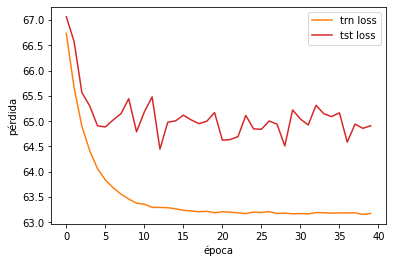

In [133]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

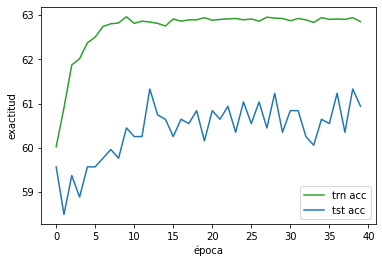

In [134]:
trn_acc_2_64, tst_acc_2_64 = zip(*acc_hist)
plt.plot(trn_acc_2_64, 'tab:green', label='trn acc')
plt.plot(tst_acc_2_64, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [135]:
model = FCN(capas=1,neuronas=2)
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-2, epochs=40)

  2%|▎         | 1/40 [00:00<00:14,  2.69it/s]

E00 loss=[ 67.30, 67.57] acc=[60.14,61.62]


  5%|▌         | 2/40 [00:00<00:14,  2.66it/s]

E01 loss=[ 65.48, 65.66] acc=[58.56,58.89]


  8%|▊         | 3/40 [00:01<00:13,  2.66it/s]

E02 loss=[ 63.91, 63.88] acc=[60.58,61.23]


 10%|█         | 4/40 [00:01<00:13,  2.64it/s]

E03 loss=[ 62.55, 62.60] acc=[61.71,61.72]


 12%|█▎        | 5/40 [00:01<00:13,  2.66it/s]

E04 loss=[ 61.30, 61.21] acc=[61.90,62.50]


 15%|█▌        | 6/40 [00:02<00:12,  2.67it/s]

E05 loss=[ 60.08, 59.99] acc=[70.21,72.75]


 18%|█▊        | 7/40 [00:02<00:12,  2.66it/s]

E06 loss=[ 58.90, 58.80] acc=[71.74,72.85]


 20%|██        | 8/40 [00:03<00:11,  2.68it/s]

E07 loss=[ 57.80, 57.45] acc=[72.61,72.95]


 22%|██▎       | 9/40 [00:03<00:11,  2.69it/s]

E08 loss=[ 56.75, 56.41] acc=[73.31,74.12]


 25%|██▌       | 10/40 [00:03<00:11,  2.66it/s]

E09 loss=[ 55.77, 55.43] acc=[73.71,75.20]


 28%|██▊       | 11/40 [00:04<00:10,  2.68it/s]

E10 loss=[ 54.91, 53.95] acc=[73.89,76.56]


 30%|███       | 12/40 [00:04<00:10,  2.68it/s]

E11 loss=[ 54.16, 53.53] acc=[74.36,76.17]


 32%|███▎      | 13/40 [00:04<00:10,  2.67it/s]

E12 loss=[ 53.55, 52.74] acc=[74.54,76.66]


 35%|███▌      | 14/40 [00:05<00:09,  2.65it/s]

E13 loss=[ 53.02, 51.96] acc=[74.56,77.05]


 38%|███▊      | 15/40 [00:05<00:09,  2.64it/s]

E14 loss=[ 52.59, 51.99] acc=[74.60,76.86]


 40%|████      | 16/40 [00:06<00:09,  2.66it/s]

E15 loss=[ 52.21, 51.68] acc=[74.75,76.56]


 42%|████▎     | 17/40 [00:06<00:08,  2.68it/s]

E16 loss=[ 51.99, 50.67] acc=[74.40,76.66]


 45%|████▌     | 18/40 [00:06<00:08,  2.67it/s]

E17 loss=[ 51.69, 51.36] acc=[74.75,75.68]


 48%|████▊     | 19/40 [00:07<00:07,  2.65it/s]

E18 loss=[ 51.44, 50.29] acc=[74.75,76.37]


 50%|█████     | 20/40 [00:07<00:07,  2.62it/s]

E19 loss=[ 51.25, 49.67] acc=[74.74,77.05]


 52%|█████▎    | 21/40 [00:07<00:07,  2.65it/s]

E20 loss=[ 51.09, 49.66] acc=[74.78,76.76]


 55%|█████▌    | 22/40 [00:08<00:06,  2.65it/s]

E21 loss=[ 51.02, 49.08] acc=[74.89,77.44]


 57%|█████▊    | 23/40 [00:08<00:06,  2.66it/s]

E22 loss=[ 50.94, 48.76] acc=[74.59,76.76]


 60%|██████    | 24/40 [00:09<00:05,  2.69it/s]

E23 loss=[ 50.83, 49.05] acc=[74.86,77.44]


 62%|██████▎   | 25/40 [00:09<00:05,  2.66it/s]

E24 loss=[ 50.78, 49.29] acc=[74.87,76.76]


 65%|██████▌   | 26/40 [00:09<00:05,  2.66it/s]

E25 loss=[ 50.67, 49.40] acc=[74.79,76.46]


 68%|██████▊   | 27/40 [00:10<00:04,  2.67it/s]

E26 loss=[ 50.62, 48.80] acc=[74.79,77.05]


 70%|███████   | 28/40 [00:10<00:04,  2.64it/s]

E27 loss=[ 50.66, 48.69] acc=[74.76,77.05]


 72%|███████▎  | 29/40 [00:10<00:04,  2.67it/s]

E28 loss=[ 50.57, 48.57] acc=[74.79,76.56]


 75%|███████▌  | 30/40 [00:11<00:03,  2.68it/s]

E29 loss=[ 50.55, 48.68] acc=[74.79,76.76]


 78%|███████▊  | 31/40 [00:11<00:03,  2.65it/s]

E30 loss=[ 50.50, 48.42] acc=[74.74,76.95]


 80%|████████  | 32/40 [00:12<00:03,  2.66it/s]

E31 loss=[ 50.59, 48.66] acc=[74.79,77.44]


 82%|████████▎ | 33/40 [00:12<00:02,  2.67it/s]

E32 loss=[ 50.48, 48.78] acc=[74.72,76.46]


 85%|████████▌ | 34/40 [00:12<00:02,  2.63it/s]

E33 loss=[ 50.44, 48.04] acc=[74.83,77.44]


 88%|████████▊ | 35/40 [00:13<00:01,  2.65it/s]

E34 loss=[ 50.45, 48.20] acc=[74.77,77.15]


 90%|█████████ | 36/40 [00:13<00:01,  2.67it/s]

E35 loss=[ 50.41, 48.40] acc=[74.86,76.95]


 92%|█████████▎| 37/40 [00:13<00:01,  2.65it/s]

E36 loss=[ 50.44, 48.94] acc=[74.74,76.76]


 95%|█████████▌| 38/40 [00:14<00:00,  2.66it/s]

E37 loss=[ 50.42, 48.51] acc=[74.82,76.56]


 98%|█████████▊| 39/40 [00:14<00:00,  2.66it/s]

E38 loss=[ 50.49, 48.72] acc=[74.76,76.56]


100%|██████████| 40/40 [00:15<00:00,  2.66it/s]

E39 loss=[ 50.39, 48.09] acc=[74.77,77.05]


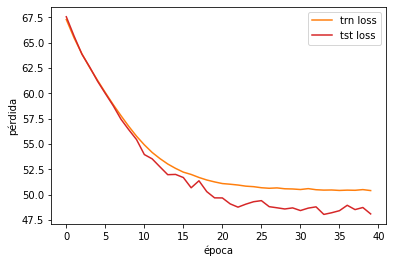

In [136]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

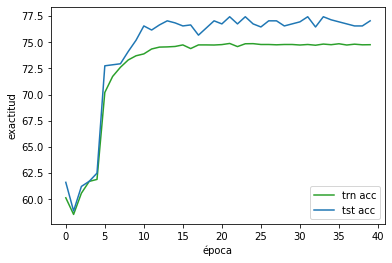

In [137]:
trn_acc_2_64, tst_acc_2_64 = zip(*acc_hist)
plt.plot(trn_acc_2_64, 'tab:green', label='trn acc')
plt.plot(tst_acc_2_64, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [145]:
model = FCN(capas=1,neuronas=4)
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-2, epochs=40)

  2%|▎         | 1/40 [00:00<00:14,  2.64it/s]

E00 loss=[ 66.10, 66.43] acc=[63.62,63.96]


  5%|▌         | 2/40 [00:00<00:14,  2.63it/s]

E01 loss=[ 63.25, 63.86] acc=[64.20,64.75]


  8%|▊         | 3/40 [00:01<00:14,  2.61it/s]

E02 loss=[ 60.86, 61.62] acc=[65.33,65.62]


 10%|█         | 4/40 [00:01<00:13,  2.62it/s]

E03 loss=[ 58.74, 59.90] acc=[70.32,70.21]


 12%|█▎        | 5/40 [00:01<00:13,  2.59it/s]

E04 loss=[ 56.79, 57.83] acc=[72.80,73.73]


 15%|█▌        | 6/40 [00:02<00:13,  2.60it/s]

E05 loss=[ 54.63, 55.99] acc=[75.86,76.37]


 18%|█▊        | 7/40 [00:02<00:12,  2.61it/s]

E06 loss=[ 51.59, 52.36] acc=[79.56,80.18]


 20%|██        | 8/40 [00:03<00:12,  2.59it/s]

E07 loss=[ 47.37, 47.72] acc=[83.52,83.59]


 22%|██▎       | 9/40 [00:03<00:11,  2.60it/s]

E08 loss=[ 43.25, 44.04] acc=[86.34,85.84]


 25%|██▌       | 10/40 [00:03<00:11,  2.61it/s]

E09 loss=[ 39.79, 40.02] acc=[87.80,88.18]


 28%|██▊       | 11/40 [00:04<00:11,  2.59it/s]

E10 loss=[ 36.92, 37.13] acc=[88.94,88.67]


 30%|███       | 12/40 [00:04<00:10,  2.59it/s]

E11 loss=[ 34.54, 34.78] acc=[89.67,89.84]


 32%|███▎      | 13/40 [00:05<00:10,  2.59it/s]

E12 loss=[ 32.50, 32.86] acc=[90.45,91.02]


 35%|███▌      | 14/40 [00:05<00:10,  2.55it/s]

E13 loss=[ 30.75, 30.45] acc=[90.86,91.21]


 38%|███▊      | 15/40 [00:05<00:09,  2.55it/s]

E14 loss=[ 29.21, 29.34] acc=[91.32,91.50]


 40%|████      | 16/40 [00:06<00:09,  2.53it/s]

E15 loss=[ 27.83, 28.22] acc=[91.84,92.29]


 42%|████▎     | 17/40 [00:06<00:08,  2.56it/s]

E16 loss=[ 26.63, 26.90] acc=[92.20,92.87]


 45%|████▌     | 18/40 [00:06<00:08,  2.56it/s]

E17 loss=[ 25.57, 25.39] acc=[92.34,93.46]


 48%|████▊     | 19/40 [00:07<00:08,  2.56it/s]

E18 loss=[ 24.62, 24.73] acc=[92.76,93.46]


 50%|█████     | 20/40 [00:07<00:07,  2.58it/s]

E19 loss=[ 23.74, 23.90] acc=[92.69,93.16]


 52%|█████▎    | 21/40 [00:08<00:07,  2.59it/s]

E20 loss=[ 22.96, 22.73] acc=[93.02,93.46]


 55%|█████▌    | 22/40 [00:08<00:07,  2.56it/s]

E21 loss=[ 22.25, 22.93] acc=[93.41,93.36]


 57%|█████▊    | 23/40 [00:08<00:06,  2.57it/s]

E22 loss=[ 21.60, 21.87] acc=[93.22,93.55]


 60%|██████    | 24/40 [00:09<00:06,  2.57it/s]

E23 loss=[ 20.99, 21.22] acc=[93.49,93.55]


 62%|██████▎   | 25/40 [00:09<00:05,  2.54it/s]

E24 loss=[ 20.47, 20.33] acc=[93.87,93.95]


 65%|██████▌   | 26/40 [00:10<00:05,  2.55it/s]

E25 loss=[ 19.94, 20.14] acc=[93.81,93.65]


 68%|██████▊   | 27/40 [00:10<00:05,  2.56it/s]

E26 loss=[ 19.45, 19.69] acc=[93.69,93.55]


 70%|███████   | 28/40 [00:10<00:04,  2.54it/s]

E27 loss=[ 19.01, 19.18] acc=[94.18,94.14]


 72%|███████▎  | 29/40 [00:11<00:04,  2.56it/s]

E28 loss=[ 18.58, 18.83] acc=[93.90,93.85]


 75%|███████▌  | 30/40 [00:11<00:03,  2.57it/s]

E29 loss=[ 18.19, 18.47] acc=[94.19,94.14]


 78%|███████▊  | 31/40 [00:12<00:03,  2.53it/s]

E30 loss=[ 17.82, 18.01] acc=[94.45,94.24]


 80%|████████  | 32/40 [00:12<00:03,  2.55it/s]

E31 loss=[ 17.47, 17.61] acc=[94.49,94.34]


 82%|████████▎ | 33/40 [00:12<00:02,  2.57it/s]

E32 loss=[ 17.16, 17.35] acc=[94.31,94.24]


 85%|████████▌ | 34/40 [00:13<00:02,  2.53it/s]

E33 loss=[ 16.84, 17.25] acc=[94.72,94.53]


 88%|████████▊ | 35/40 [00:13<00:01,  2.54it/s]

E34 loss=[ 16.54, 17.10] acc=[94.60,94.14]


 90%|█████████ | 36/40 [00:14<00:01,  2.53it/s]

E35 loss=[ 16.26, 16.50] acc=[94.58,94.53]


 92%|█████████▎| 37/40 [00:14<00:01,  2.53it/s]

E36 loss=[ 16.02, 16.33] acc=[94.93,94.63]


 95%|█████████▌| 38/40 [00:14<00:00,  2.56it/s]

E37 loss=[ 15.75, 16.02] acc=[94.82,94.43]


 98%|█████████▊| 39/40 [00:15<00:00,  2.57it/s]

E38 loss=[ 15.53, 15.90] acc=[94.97,94.63]


100%|██████████| 40/40 [00:15<00:00,  2.57it/s]

E39 loss=[ 15.30, 15.68] acc=[95.16,94.82]


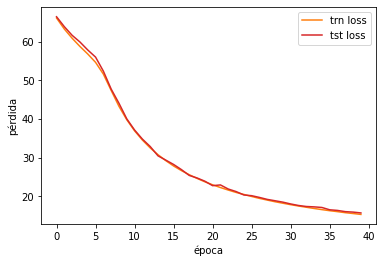

In [146]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

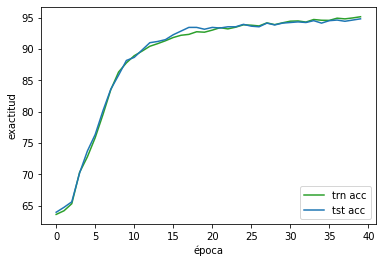

In [147]:
trn_acc_2_64, tst_acc_2_64 = zip(*acc_hist)
plt.plot(trn_acc_2_64, 'tab:green', label='trn acc')
plt.plot(tst_acc_2_64, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

## Dos capas

In [148]:
model = FCN(capas=2,neuronas=1)
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-2, epochs=40)

  2%|▎         | 1/40 [00:00<00:14,  2.72it/s]

E00 loss=[ 69.61, 69.80] acc=[50.42,49.32]


  5%|▌         | 2/40 [00:00<00:14,  2.70it/s]

E01 loss=[ 69.33, 69.37] acc=[50.39,49.61]


  8%|▊         | 3/40 [00:01<00:13,  2.67it/s]

E02 loss=[ 69.31, 69.32] acc=[50.38,50.20]


 10%|█         | 4/40 [00:01<00:13,  2.63it/s]

E03 loss=[ 69.31, 69.33] acc=[50.40,49.61]


 12%|█▎        | 5/40 [00:01<00:13,  2.67it/s]

E04 loss=[ 69.32, 69.31] acc=[49.63,50.68]


 15%|█▌        | 6/40 [00:02<00:12,  2.69it/s]

E05 loss=[ 69.31, 69.32] acc=[50.42,49.90]


 18%|█▊        | 7/40 [00:02<00:12,  2.67it/s]

E06 loss=[ 69.31, 69.32] acc=[50.40,49.90]


 20%|██        | 8/40 [00:02<00:11,  2.70it/s]

E07 loss=[ 69.31, 69.31] acc=[50.39,50.20]


 22%|██▎       | 9/40 [00:03<00:11,  2.70it/s]

E08 loss=[ 69.31, 69.31] acc=[50.39,50.78]


 25%|██▌       | 10/40 [00:03<00:11,  2.68it/s]

E09 loss=[ 69.31, 69.31] acc=[50.41,50.20]


 28%|██▊       | 11/40 [00:04<00:10,  2.70it/s]

E10 loss=[ 69.31, 69.32] acc=[50.37,49.61]


 30%|███       | 12/40 [00:04<00:10,  2.71it/s]

E11 loss=[ 69.31, 69.32] acc=[50.42,49.90]


 32%|███▎      | 13/40 [00:04<00:10,  2.69it/s]

E12 loss=[ 69.31, 69.32] acc=[50.41,49.61]


 35%|███▌      | 14/40 [00:05<00:09,  2.69it/s]

E13 loss=[ 69.31, 69.33] acc=[50.42,49.61]


 38%|███▊      | 15/40 [00:05<00:09,  2.69it/s]

E14 loss=[ 69.31, 69.33] acc=[50.42,49.90]


 40%|████      | 16/40 [00:05<00:08,  2.67it/s]

E15 loss=[ 69.31, 69.31] acc=[50.37,50.49]


 42%|████▎     | 17/40 [00:06<00:08,  2.65it/s]

E16 loss=[ 69.31, 69.33] acc=[50.41,49.90]


 45%|████▌     | 18/40 [00:06<00:08,  2.67it/s]

E17 loss=[ 69.31, 69.34] acc=[50.40,49.61]


 48%|████▊     | 19/40 [00:07<00:07,  2.65it/s]

E18 loss=[ 69.31, 69.33] acc=[50.40,49.32]


 50%|█████     | 20/40 [00:07<00:07,  2.61it/s]

E19 loss=[ 69.31, 69.34] acc=[50.43,49.61]


 52%|█████▎    | 21/40 [00:07<00:07,  2.64it/s]

E20 loss=[ 69.31, 69.32] acc=[50.39,49.61]


 55%|█████▌    | 22/40 [00:08<00:06,  2.65it/s]

E21 loss=[ 69.31, 69.32] acc=[50.40,49.90]


 57%|█████▊    | 23/40 [00:08<00:06,  2.65it/s]

E22 loss=[ 69.31, 69.31] acc=[50.37,50.49]


 60%|██████    | 24/40 [00:08<00:05,  2.68it/s]

E23 loss=[ 69.31, 69.32] acc=[50.40,50.20]


 62%|██████▎   | 25/40 [00:09<00:05,  2.65it/s]

E24 loss=[ 69.31, 69.32] acc=[50.39,49.90]


 65%|██████▌   | 26/40 [00:09<00:05,  2.66it/s]

E25 loss=[ 69.31, 69.32] acc=[50.39,49.61]


 68%|██████▊   | 27/40 [00:10<00:04,  2.67it/s]

E26 loss=[ 69.31, 69.33] acc=[50.40,49.61]


 70%|███████   | 28/40 [00:10<00:04,  2.64it/s]

E27 loss=[ 69.31, 69.31] acc=[50.38,50.20]


 72%|███████▎  | 29/40 [00:10<00:04,  2.68it/s]

E28 loss=[ 69.31, 69.32] acc=[50.41,50.20]


 75%|███████▌  | 30/40 [00:11<00:03,  2.71it/s]

E29 loss=[ 69.31, 69.31] acc=[50.36,50.20]


 78%|███████▊  | 31/40 [00:11<00:03,  2.65it/s]

E30 loss=[ 69.31, 69.32] acc=[50.38,50.20]


 80%|████████  | 32/40 [00:11<00:02,  2.68it/s]

E31 loss=[ 69.31, 69.32] acc=[50.41,49.90]


 82%|████████▎ | 33/40 [00:12<00:02,  2.69it/s]

E32 loss=[ 69.31, 69.32] acc=[50.39,49.90]


 85%|████████▌ | 34/40 [00:12<00:02,  2.69it/s]

E33 loss=[ 69.31, 69.34] acc=[50.42,49.61]


 88%|████████▊ | 35/40 [00:13<00:01,  2.72it/s]

E34 loss=[ 69.31, 69.31] acc=[50.37,50.20]


 90%|█████████ | 36/40 [00:13<00:01,  2.72it/s]

E35 loss=[ 69.32, 69.31] acc=[49.59,50.10]


 92%|█████████▎| 37/40 [00:13<00:01,  2.70it/s]

E36 loss=[ 69.31, 69.31] acc=[50.40,50.49]


 95%|█████████▌| 38/40 [00:14<00:00,  2.72it/s]

E37 loss=[ 69.31, 69.32] acc=[50.44,49.90]


 98%|█████████▊| 39/40 [00:14<00:00,  2.67it/s]

E38 loss=[ 69.31, 69.32] acc=[50.37,49.90]


100%|██████████| 40/40 [00:14<00:00,  2.68it/s]

E39 loss=[ 69.31, 69.33] acc=[50.39,49.32]


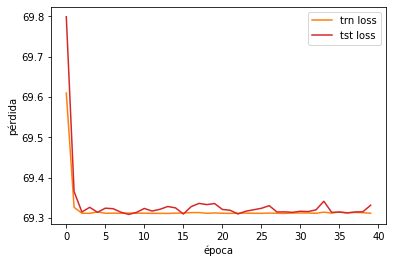

In [149]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

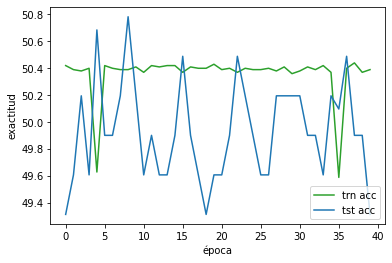

In [150]:
trn_acc_2_64, tst_acc_2_64 = zip(*acc_hist)
plt.plot(trn_acc_2_64, 'tab:green', label='trn acc')
plt.plot(tst_acc_2_64, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [138]:
model = FCN(capas=2,neuronas=2)
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-2, epochs=40)

  2%|▎         | 1/40 [00:00<00:16,  2.38it/s]

E00 loss=[ 67.83, 67.89] acc=[65.56,66.60]


  5%|▌         | 2/40 [00:00<00:16,  2.35it/s]

E01 loss=[ 66.42, 66.42] acc=[68.92,69.63]


  8%|▊         | 3/40 [00:01<00:15,  2.33it/s]

E02 loss=[ 64.02, 63.99] acc=[71.11,71.58]


 10%|█         | 4/40 [00:01<00:15,  2.33it/s]

E03 loss=[ 60.47, 60.09] acc=[73.43,74.90]


 12%|█▎        | 5/40 [00:02<00:15,  2.31it/s]

E04 loss=[ 56.52, 55.92] acc=[74.54,76.86]


 15%|█▌        | 6/40 [00:02<00:14,  2.33it/s]

E05 loss=[ 53.78, 52.68] acc=[74.76,76.95]


 18%|█▊        | 7/40 [00:03<00:14,  2.33it/s]

E06 loss=[ 52.29, 50.94] acc=[74.77,76.56]


 20%|██        | 8/40 [00:03<00:13,  2.32it/s]

E07 loss=[ 51.51, 50.16] acc=[74.73,76.27]


 22%|██▎       | 9/40 [00:03<00:13,  2.31it/s]

E08 loss=[ 51.05, 49.18] acc=[74.89,77.73]


 25%|██▌       | 10/40 [00:04<00:12,  2.31it/s]

E09 loss=[ 50.81, 49.96] acc=[74.80,75.78]


 28%|██▊       | 11/40 [00:04<00:12,  2.28it/s]

E10 loss=[ 50.65, 49.17] acc=[74.73,76.66]


 30%|███       | 12/40 [00:05<00:12,  2.29it/s]

E11 loss=[ 50.56, 48.95] acc=[74.75,76.66]


 32%|███▎      | 13/40 [00:05<00:11,  2.30it/s]

E12 loss=[ 50.53, 49.57] acc=[74.83,76.66]


 35%|███▌      | 14/40 [00:06<00:11,  2.28it/s]

E13 loss=[ 50.44, 48.50] acc=[74.74,77.44]


 38%|███▊      | 15/40 [00:06<00:10,  2.29it/s]

E14 loss=[ 50.37, 48.29] acc=[74.87,77.25]


 40%|████      | 16/40 [00:06<00:10,  2.29it/s]

E15 loss=[ 50.34, 48.12] acc=[74.79,77.34]


 42%|████▎     | 17/40 [00:07<00:10,  2.29it/s]

E16 loss=[ 50.29, 48.26] acc=[74.76,76.76]


 45%|████▌     | 18/40 [00:07<00:09,  2.28it/s]

E17 loss=[ 50.27, 48.30] acc=[74.85,76.86]


 48%|████▊     | 19/40 [00:08<00:09,  2.30it/s]

E18 loss=[ 50.25, 48.68] acc=[74.78,76.17]


 50%|█████     | 20/40 [00:08<00:08,  2.30it/s]

E19 loss=[ 50.26, 48.68] acc=[74.69,76.56]


 52%|█████▎    | 21/40 [00:09<00:08,  2.31it/s]

E20 loss=[ 50.26, 48.94] acc=[74.82,76.27]


 55%|█████▌    | 22/40 [00:09<00:07,  2.32it/s]

E21 loss=[ 50.20, 48.02] acc=[74.86,77.05]


 57%|█████▊    | 23/40 [00:09<00:07,  2.32it/s]

E22 loss=[ 50.23, 48.27] acc=[74.78,76.86]


 60%|██████    | 24/40 [00:10<00:06,  2.32it/s]

E23 loss=[ 50.21, 47.97] acc=[74.77,77.05]


 62%|██████▎   | 25/40 [00:10<00:06,  2.32it/s]

E24 loss=[ 50.20, 48.32] acc=[74.83,76.66]


 65%|██████▌   | 26/40 [00:11<00:06,  2.28it/s]

E25 loss=[ 50.25, 47.93] acc=[74.72,76.95]


 68%|██████▊   | 27/40 [00:11<00:05,  2.29it/s]

E26 loss=[ 50.19, 48.24] acc=[74.79,76.27]


 70%|███████   | 28/40 [00:12<00:05,  2.29it/s]

E27 loss=[ 50.24, 48.35] acc=[74.65,76.76]


 72%|███████▎  | 29/40 [00:12<00:04,  2.28it/s]

E28 loss=[ 50.26, 48.77] acc=[74.86,76.76]


 75%|███████▌  | 30/40 [00:13<00:04,  2.29it/s]

E29 loss=[ 50.26, 48.08] acc=[74.95,77.25]


 78%|███████▊  | 31/40 [00:13<00:03,  2.30it/s]

E30 loss=[ 50.24, 47.86] acc=[74.75,77.15]


 80%|████████  | 32/40 [00:13<00:03,  2.27it/s]

E31 loss=[ 50.24, 47.69] acc=[74.70,77.05]


 82%|████████▎ | 33/40 [00:14<00:03,  2.28it/s]

E32 loss=[ 50.24, 48.36] acc=[74.69,77.05]


 85%|████████▌ | 34/40 [00:14<00:02,  2.30it/s]

E33 loss=[ 50.22, 48.12] acc=[74.81,77.05]


 88%|████████▊ | 35/40 [00:15<00:02,  2.28it/s]

E34 loss=[ 50.23, 47.76] acc=[74.81,76.95]


 90%|█████████ | 36/40 [00:15<00:01,  2.30it/s]

E35 loss=[ 50.21, 48.15] acc=[74.80,76.95]


 92%|█████████▎| 37/40 [00:16<00:01,  2.31it/s]

E36 loss=[ 50.30, 47.83] acc=[74.87,77.44]


 95%|█████████▌| 38/40 [00:16<00:00,  2.30it/s]

E37 loss=[ 50.21, 48.33] acc=[74.79,76.76]


 98%|█████████▊| 39/40 [00:16<00:00,  2.32it/s]

E38 loss=[ 50.20, 48.00] acc=[74.81,76.86]


100%|██████████| 40/40 [00:17<00:00,  2.30it/s]

E39 loss=[ 50.19, 48.06] acc=[74.77,76.76]


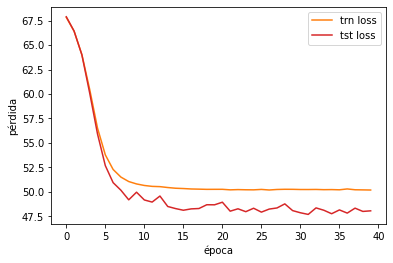

In [139]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

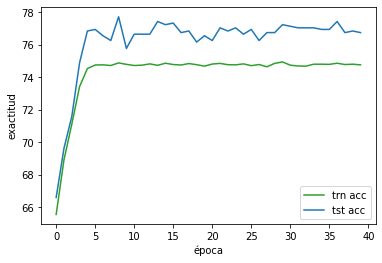

In [140]:
trn_acc_2_64, tst_acc_2_64 = zip(*acc_hist)
plt.plot(trn_acc_2_64, 'tab:green', label='trn acc')
plt.plot(tst_acc_2_64, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [141]:
model = FCN(capas=2,neuronas=4)
loss_hist, acc_hist = train(model, trn_dl, tst_dl, lr=1e-2, epochs=40)

  2%|▎         | 1/40 [00:00<00:20,  1.94it/s]

E00 loss=[ 68.37, 68.45] acc=[56.75,55.76]


  5%|▌         | 2/40 [00:00<00:18,  2.02it/s]

E01 loss=[ 67.14, 67.30] acc=[58.91,59.08]


  8%|▊         | 3/40 [00:01<00:17,  2.09it/s]

E02 loss=[ 65.36, 65.51] acc=[74.50,77.05]


 10%|█         | 4/40 [00:01<00:16,  2.12it/s]

E03 loss=[ 62.78, 62.77] acc=[63.70,64.75]


 12%|█▎        | 5/40 [00:02<00:16,  2.18it/s]

E04 loss=[ 59.11, 58.86] acc=[76.82,79.69]


 15%|█▌        | 6/40 [00:02<00:15,  2.23it/s]

E05 loss=[ 53.91, 53.25] acc=[82.62,84.96]


 18%|█▊        | 7/40 [00:03<00:14,  2.23it/s]

E06 loss=[ 47.62, 47.21] acc=[86.66,87.99]


 20%|██        | 8/40 [00:03<00:14,  2.27it/s]

E07 loss=[ 41.00, 40.35] acc=[89.72,90.43]


 22%|██▎       | 9/40 [00:04<00:13,  2.27it/s]

E08 loss=[ 35.13, 34.11] acc=[91.76,92.09]


 25%|██▌       | 10/40 [00:04<00:13,  2.26it/s]

E09 loss=[ 30.47, 29.51] acc=[93.42,94.04]


 28%|██▊       | 11/40 [00:04<00:12,  2.27it/s]

E10 loss=[ 26.85, 26.80] acc=[94.47,94.04]


 30%|███       | 12/40 [00:05<00:12,  2.27it/s]

E11 loss=[ 24.07, 23.71] acc=[95.01,94.82]


 32%|███▎      | 13/40 [00:05<00:11,  2.28it/s]

E12 loss=[ 21.89, 21.45] acc=[95.25,95.02]


 35%|███▌      | 14/40 [00:06<00:11,  2.27it/s]

E13 loss=[ 20.14, 19.60] acc=[95.49,95.90]


 38%|███▊      | 15/40 [00:06<00:10,  2.28it/s]

E14 loss=[ 18.70, 18.04] acc=[95.63,95.90]


 40%|████      | 16/40 [00:07<00:10,  2.27it/s]

E15 loss=[ 17.54, 17.96] acc=[96.13,96.19]


 42%|████▎     | 17/40 [00:07<00:10,  2.29it/s]

E16 loss=[ 16.60, 16.12] acc=[95.68,96.00]


 45%|████▌     | 18/40 [00:07<00:09,  2.29it/s]

E17 loss=[ 15.78, 15.22] acc=[95.92,96.29]


 48%|████▊     | 19/40 [00:08<00:09,  2.30it/s]

E18 loss=[ 14.93, 14.19] acc=[96.59,97.27]


 50%|█████     | 20/40 [00:08<00:08,  2.30it/s]

E19 loss=[ 14.39, 14.00] acc=[96.36,97.07]


 52%|█████▎    | 21/40 [00:09<00:08,  2.30it/s]

E20 loss=[ 13.71, 13.35] acc=[97.02,97.46]


 55%|█████▌    | 22/40 [00:09<00:07,  2.25it/s]

E21 loss=[ 13.14, 12.75] acc=[96.87,97.56]


 57%|█████▊    | 23/40 [00:10<00:07,  2.27it/s]

E22 loss=[ 12.70, 12.48] acc=[97.02,97.36]


 60%|██████    | 24/40 [00:10<00:07,  2.27it/s]

E23 loss=[ 12.22, 11.90] acc=[97.12,97.75]


 62%|██████▎   | 25/40 [00:11<00:06,  2.29it/s]

E24 loss=[ 11.84, 11.81] acc=[97.23,97.85]


 65%|██████▌   | 26/40 [00:11<00:06,  2.30it/s]

E25 loss=[ 12.07, 11.74] acc=[96.36,96.29]


 68%|██████▊   | 27/40 [00:11<00:05,  2.29it/s]

E26 loss=[ 11.08, 10.85] acc=[97.45,98.05]


 70%|███████   | 28/40 [00:12<00:05,  2.28it/s]

E27 loss=[ 11.12, 11.15] acc=[97.03,96.58]


 72%|███████▎  | 29/40 [00:12<00:04,  2.30it/s]

E28 loss=[ 10.47, 10.37] acc=[97.52,97.36]


 75%|███████▌  | 30/40 [00:13<00:04,  2.28it/s]

E29 loss=[ 10.15,  9.94] acc=[97.38,97.46]


 78%|███████▊  | 31/40 [00:13<00:03,  2.29it/s]

E30 loss=[  9.94,  9.70] acc=[97.29,97.66]


 80%|████████  | 32/40 [00:14<00:03,  2.29it/s]

E31 loss=[  9.53,  9.22] acc=[97.80,98.14]


 82%|████████▎ | 33/40 [00:14<00:03,  2.28it/s]

E32 loss=[  9.28,  9.19] acc=[98.01,97.66]


 85%|████████▌ | 34/40 [00:14<00:02,  2.30it/s]

E33 loss=[  8.97,  8.70] acc=[98.20,98.44]


 88%|████████▊ | 35/40 [00:15<00:02,  2.29it/s]

E34 loss=[  8.76,  8.39] acc=[98.25,98.44]


 90%|█████████ | 36/40 [00:15<00:01,  2.28it/s]

E35 loss=[  8.63,  8.48] acc=[98.09,98.14]


 92%|█████████▎| 37/40 [00:16<00:01,  2.29it/s]

E36 loss=[  8.29,  8.09] acc=[98.22,98.54]


 95%|█████████▌| 38/40 [00:16<00:00,  2.30it/s]

E37 loss=[  8.13,  7.78] acc=[98.22,98.34]


 98%|█████████▊| 39/40 [00:17<00:00,  2.27it/s]

E38 loss=[  7.93,  7.86] acc=[97.96,97.66]


100%|██████████| 40/40 [00:17<00:00,  2.27it/s]

E39 loss=[  7.68,  7.56] acc=[98.34,98.54]


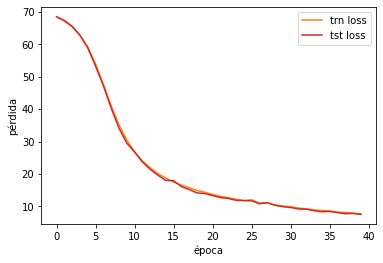

In [142]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

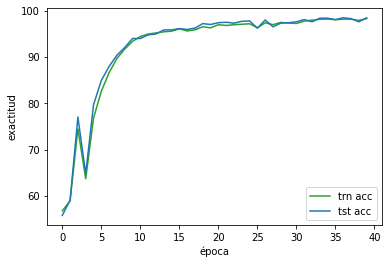

In [143]:
trn_acc_2_64, tst_acc_2_64 = zip(*acc_hist)
plt.plot(trn_acc_2_64, 'tab:green', label='trn acc')
plt.plot(tst_acc_2_64, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

El problema aquí es que se le tienen que poner más capas ocultas con más neuronas para que lo pueda resolver de mejor manera. Ya vimos que no se puede resolver con una sola neurona, o al menos no se tienen buenos resultados con esto, más bien lo hace lineal y siempre tendrá alrededor de 50% en accuracy. Al irle metiendo más capas y más neuronas se tienen mejores resultados hasta casi tener una exactitud del 100% con sólo dos capas y 4 neuronas.